In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

# Helper Functions

## Camera Calibration

In [2]:
def calibrate(images=[], nx=5, ny=5, verbose=False):
    '''
    Calculates the camera calibration parameters using samples of chessboard images.

    Parameters:
        images: array of image locations
        nx: number of non-edge chessboard corners on the x-axis
        ny: number of non-edge chessboard corners on the y-axis
        verbose: summarize calibration results

    Returns:
        ret, mtx, dist, rvec, tvec: camera calibration parameters
    '''

    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in the image plane

    # nx Number of grids in x-axis
    # ny Number of grids in y-axis

    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    valid_images = 0
    total_images = len(images)

    # Subpixel refinement criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    for image in images:
        img = mpimg.imread(image)
        # Creating a grayscale image for the corner detection
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        #TODO: Add 8-bit image check, which is necessary if a .png is imported instead of a .jpg
        # Conversion is (gray*255).astype(np.uint8)

        # Finding chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If corners are found, add the object and image points
        if ret == True:
            corners = cv2.cornerSubPix(gray, corners, (nx,ny), (-1,-1), criteria)
            imgpoints.append(corners)
            objpoints.append(objp)
            valid_images += 1

    if verbose == True:
        print('{} of the {} calibration images were valid'.format(valid_images, total_images))

    # Calibrate the camera using the object and image points
    img_shape = cv2.cvtColor(mpimg.imread(images[0]), cv2.COLOR_RGB2GRAY).shape[::-1]
    ret, mtx, dist, rvec, tvec = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)
    return ret, mtx, dist, rvec, tvec

# Camera Calibration

> Samples of chessboard images will be used to calibrate a single lens

## Camera 1

In [16]:
camera_1_cal = glob.glob('calibration/camera_1/*.jpeg')
ret, mtx, dist, rvec, tvec = calibrate(camera_1_cal,9,6)

### Visualization

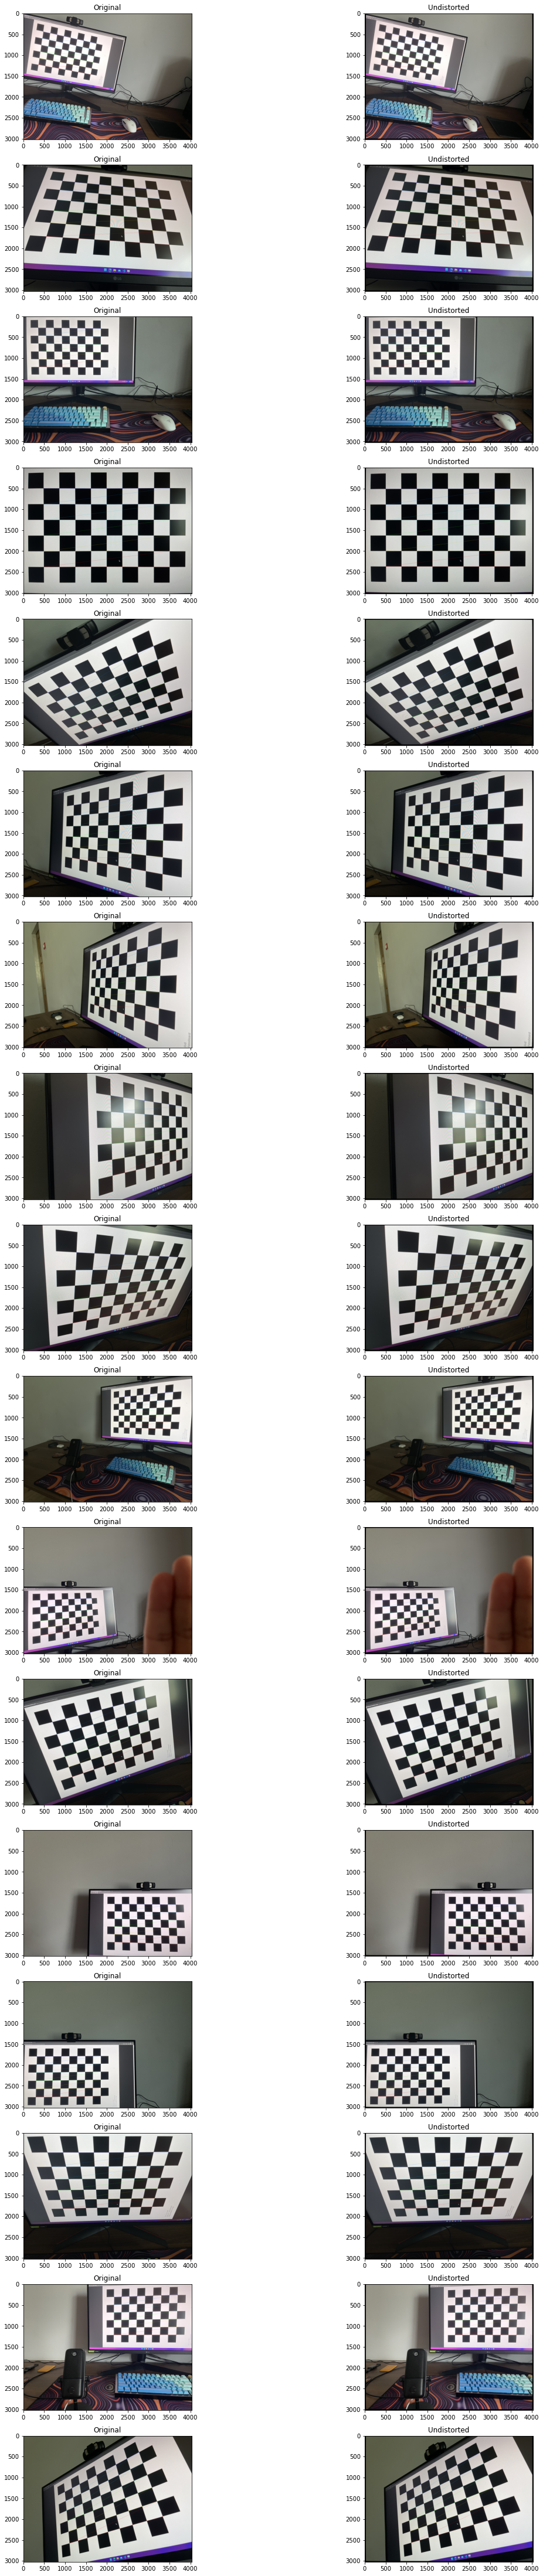

In [17]:
# Creating a grid for test plots
gs = gridspec.GridSpec(np.ceil(len(camera_1_cal)).astype(np.int32), 4)
gs.update(wspace=0.2, hspace=0.2)
plt.figure(figsize=(20,80))
ax = []

for (i, image) in enumerate(camera_1_cal):
    img = mpimg.imread(image)
    ret, corners = cv2.findChessboardCorners(img, (9,6), None)
    if ret == True:
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

    # Undistort
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    # Append plots to a list
    plot = plt.subplot(gs[i, :2])
    plot.set_title('Original')
    plot.imshow(img)
    ax.append(plot)
    plot = plt.subplot(gs[i, 2:], )
    plot.set_title('Undistorted')
    plot.imshow(dst)
    ax.append(plot)
    

## Camera 2

In [ ]:
# camera_2_cal = glob.glob('calibration/camera_2/*.jpeg')
# ret, mtx, dist, rvec, tvec = calibrate(camera_2_cal,9,6)